# Foundations of Computational Economics #27

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Dynamic programming in discrete world

<img src="_static/img/lecture.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/kpNGDQnDpmU](https://youtu.be/kpNGDQnDpmU)

Description: Backwards induction. Tiling problem. Deal or no deal game. Bellman optimality principle. Inventory dynamics model.

### What is dynamic programming?

**“DP is recursive method for solving sequential decision problems”**

📖 Rust 2006, *New Palgrave Dictionary of Economics*

In computer science the meaning of the term is broader:
**DP is a general algorithm design technique for solving problems with
overlapping sub-problems.**

Generally allows solving in polynomial time $ O(n^k) $ problems that would
otherwise take exponential time  $ O(a^n) $

#### Tiling with dominoes example

Given a $ 3 \times n $ board, find **the number of ways** to
fill it with $ 2 \times 1 $ dominoes.

#### Examples of tiling

These are three possible ways to fill up $ 3 \times 2 $ board

<img src="_static/img/tile1.jpg" style="height:100px;">

This is one possible way to tile $ 3 \times 8 $ board

<img src="_static/img/tile2.jpg" style="height:100px;">

The problem is to compute the number of possible tilings for any $ 3 \times n $ board.

#### Breaking the big problem into subproblems

Observe that at any possible stage of filling up a $ 3 \times n $ board we may have
the following configurations

<img src="_static/img/tile3.jpg" style="height:180px;">

And it is impossible to have the following configurations

<img src="_static/img/tile4.jpg" style="height:150px;">

#### Defining the recursion

The case of $ A_n $:

<img src="_static/img/tile5.jpg" style="height:120px;">

The case of $ B_n $:

<img src="_static/img/tile6.jpg" style="height:120px;">

The case of $ C_n $ is identical to $ B_n $, i.e. $ C_n = B_n $

#### Recursive solution

Therefore for any $ n $ we have

$$
\begin{eqnarray*}
A_n &=& A_{n-2} + 2 B_{n-1} \\
B_n &=& A_{n-1} + B_{n-2}
\end{eqnarray*}
$$

The answer to the whole problem is given by $ A_n $

1. Inductive computation of the two sequences.  
1. Can be improved by *memoization* (optimization technique based on caching previous calls to the function)  

In [1]:
def WaysTileDominoes(n):
    '''Compute the number of ways to tile 3 x n area by 2x1 tiles'''
    A, B = [0] * (n + 1),[0] * (n + 1)
    A[0] = 1 # one way to tile 3x0
    A[1] = 0 # no way to tile 3x1
    B[0] = 0 # no way to tile 3x0 without a corner
    B[1] = 1 # one way to tile 3x1 without a corner
    for i in range(2, n+1): # loop over 2,3,..,n
        A[i] = A[i-2] + 2 * B[i-1]
        B[i] = A[i-1] + B[i-2]
    return A[n]

In [2]:
for n in range(1,20):
    print('There are',WaysTileDominoes(n),'ways to tile the 3 by',n,'board')

There are 0 ways to tile the 3 by 1 board
There are 3 ways to tile the 3 by 2 board
There are 0 ways to tile the 3 by 3 board
There are 11 ways to tile the 3 by 4 board
There are 0 ways to tile the 3 by 5 board
There are 41 ways to tile the 3 by 6 board
There are 0 ways to tile the 3 by 7 board
There are 153 ways to tile the 3 by 8 board
There are 0 ways to tile the 3 by 9 board
There are 571 ways to tile the 3 by 10 board
There are 0 ways to tile the 3 by 11 board
There are 2131 ways to tile the 3 by 12 board
There are 0 ways to tile the 3 by 13 board
There are 7953 ways to tile the 3 by 14 board
There are 0 ways to tile the 3 by 15 board
There are 29681 ways to tile the 3 by 16 board
There are 0 ways to tile the 3 by 17 board
There are 110771 ways to tile the 3 by 18 board
There are 0 ways to tile the 3 by 19 board


### Deal or no deal example

Consider a version of [Deal or no deal](https://en.wikipedia.org/wiki/Deal_or_No_Deal) TV show game

- the player is presented with $ n $ boxes with prizes hidden inside  
- all prizes $ x_1,\dots,x_n $ are known to the player, but not where they are  
- at each round the player may choose a box at random to be removed from the game (and loose the opportunity to get the prize within)  
- otherwise, the player may choose to stop the game and walk away with the prize chosen randomly from remaining boxes  


What is the optimal strategy to maximize the (expected) reward?

#### Need assumption about the reward evaluation

- assume that the player is maximizing the expected reward  
- ok, but then for each set of remaining prizes $ (x,y,z) $ the expected reward is  


$$
\frac{x+y+z}{3} \text{  (stopping the game)}
$$

$$
\frac{1}{3}\cdot\frac{x+y}{2} + \frac{1}{3}\cdot\frac{x+z}{2} + \frac{1}{3}\cdot\frac{y+z}{2} \text{  (removing random box)}
$$

- at each point of the game the player will be indifferent between stopping or continuing the game  
- thus, optimal strategy is to stop at the first round and take random reward!  

#### Loss aversion utility

- assume that the player has loss aversion utility of the form  


$$
U(\text{reward},\text{reference}) = \text{reward} - \theta \cdot \mathbb{1}\{ \text{reward}< \text{reference}\}
$$

- if award is below the reference level, there is a cut in utility  
- assume further that the reference level is *updated* endogenously during the game:  
- at each round equal to the foregone option of stopping the game in the previous round  

#### How to solve for the optimal strategy in this game?

1. What is the maximum number of rounds in the game?  
1. What does the optimal choice depend on in each round?  
1. What is the *complete* strategy in the game?  

- for a given round let $ B $ denote the set of remaining $ n $ boxes/prizes  
- denote $ r $ the reference level in the utility function $ U(\cdot,r) $  


Let $ V(B,r) $ be the maximum expected reward, i.e. assuming optimal strategy is played from this round on

$$
V(B,r) = \max\Big[ \underbrace{\tfrac{1}{n} \sum_{b \in B} U(b,r)}_{\text{stop}} ;
                   \underbrace{\sum_{b \in B} \tfrac{1}{n} V\big(B \backslash b, \tfrac{1}{n} \sum_{d \in B} U(d,r)\big)  }_{\text{continue}}
                 \Big]
$$

$$
V(B,r) = \max\big[ R_r ; \sum_{b \in B} \tfrac{1}{n} V(B \backslash b, R_r) \big]
$$

- $ R_r = \tfrac{1}{n} \sum_{b \in B} U(b,r) $ is current round expected reward  
- $ B \backslash b $ is the next round set of $ n-1 $ boxes/prizes  

In [3]:
def expected_reward(boxes,ref=None,loss_aversion_param=.1,verbose=True):
    '''Compute the expected reward from the game with given boxed prizes and the reference level'''
    n = len(boxes)  # number of boxed remaining
    ref = sum(boxes)/n if ref is None else ref  # default reference level
    # reward if stopping
    current = [b - loss_aversion_param*(b<ref) for b in boxes]
    current = sum(current)/n  # average
    # expected reward if continuing the game
    if n==1:
        next = current  # the same if only one box left
    else:
        next = 0.  # initialize
        for i in range(n):  # accumulate expected reward component by component
            next += expected_reward(boxes[:i]+boxes[i+1:],current,loss_aversion_param,verbose)
        next /= n  # take average
    if verbose:
        print('%-20s'%''.join('[{}]'.format(b) for b in boxes),end='')  # this round boxes
        print(' ref={:<6.3f}'.format(ref),end='')                       # this round reference level
        if n>1:
            print(' reward if stop={:<6.3f} if continue={:<6.3f}'.format(current,next),end='')  # rewards for two decisions
            print('  >> {}!'.format('stop' if current >= next else 'continue'))                 # best decision
        else:
            print(' reward={:<6.3f}'.format(current))   # reward in case of last box left
    return max(current,next)  # reward from the optimal choice

In [4]:
import math
boxes = [int(math.exp(b)) for b in range(3)]  # uneven prizes
print('Initial prizes = ',boxes)
expected_reward(boxes,loss_aversion_param=0.1);

Initial prizes =  [1, 2, 7]
[7]                  ref=4.450  reward=7.000 
[2]                  ref=4.450  reward=1.900 
[2][7]               ref=3.267  reward if stop=4.450  if continue=4.450   >> stop!
[7]                  ref=3.950  reward=7.000 
[1]                  ref=3.950  reward=0.900 
[1][7]               ref=3.267  reward if stop=3.950  if continue=3.950   >> stop!
[2]                  ref=1.400  reward=2.000 
[1]                  ref=1.400  reward=0.900 
[1][2]               ref=3.267  reward if stop=1.400  if continue=1.450   >> continue!
[1][2][7]            ref=3.333  reward if stop=3.267  if continue=3.283   >> continue!


#### Bellman’s Principle of Optimality

“An optimal policy has a property that whatever the initial state and
initial decision are, the remaining decisions must constitute an
optimal policy with regard to the state resulting from the first
decision.”

📖 Bellman, 1957 “Dynamic Programming”

#### Breaking the problem into sequence of small problems

- Thus, the sequential decision problem is broken into *initial decision*
  problem and the *future decisions* problem  
- The solution can be computed through **backward induction**,
  i.e. solving a sequential decision problem from the later periods  
- Embodiment of the recursive way of modeling sequential decisions is
  **Bellman equation**  

#### Bellman equation

$$
V(\text{state}) = \max_{\text{decisions}} \big[ U(\text{state},\text{decision}) + \beta \mathbb{E}\big\{ V(\text{next state})  \big| \text{state},\text{decision} \big\} \big]
$$

- $ V(\text{state}) $ is **value function** = maximum attainable (discounted) expected reward/utility/payoff  
- $ U(\text{state},\text{decision}) $ is per-period/flow/instantaneous reward/utility/payoff  
- (*next state*) is the *stochastic* next period state resulting from current state and decision  
- expectation $ \mathbb{E}\{\cdot\} $ is taken over the distribution of the next period state conditional on current state and decision  
- $ \beta $ is a discount factor to measure future rewards in terms of current ones  


The optimal choices are revealed along the solution of the Bellman equation as decisions which solve the maximization problem in the right hand side!

#### Bellman equation in deterministic models

In deterministic case, expectation is not necessary:

$$
V(\text{state}) = \max_{\text{decisions}} \big[ U(\text{state},\text{decision}) + \beta \cdot V(\text{next state}) \big]
$$

#### Bellman equation in models with finite horizon

Additional condition at the final period $ t=T $, usually

$$
V(\text{state}) = \max_{\text{decisions}} \big[ U(\text{state},\text{decision}) \big] \text{ at terminal period } T
$$

In other words, as if $ V(\text{at } T +1 ) = \mathbb{0} $

#### Power of dynamic programming

DP is a the main tool in analyzing modern micro and macto economic models

DP is powerful due to its **flexibility and breadth**

DP provides a framework to study decision making over time and under uncertainty
and can accommodate learning, strategic interactions between agents (game theory)
and market interactions (equilibrium theory)

#### Dynamic programming in economics

Many important problems and economic models are analyzed and solved
using dynamic programming:

- Dynamic models of labor supply  
- Job search  
- Human capital accumulation  
- Health process, insurance and long term care  
- Consumption/savings choices  
- Durable consumption  
- Growth models  
- Heterogeneous agents models  
- Overlapping generation models  

#### Origin of the term Dynamic Programming

📖 Bellman’s autobiography “The Eye of the Hurricane”

The 1950’s were not good years for mathematical research. We had a very interesting
gentleman in Washington named Wilson. He was Secretary of Defence, and
he actually had a pathological fear and hatred of the word “research”.

I’m not using the term lightly; I’m using it precisely. His face would
suffuse, he would turn red, and he would get violent if people used the
term, research, in his presence. You can imagine how he felt, then,
about the term, mathematical.

Hence, I felt I had to do something to shield Wilson and the Air Force
from the fact that I was really doing mathematics inside the RAND Corporation.

What title, what name, could I choose?

In the first place, I was interested in planning, in
decision-making, in thinking. But planning, is not a good word for
various reasons. I decided therefore to use the word, “programming”.

I wanted to get across the idea that this was dynamic, this was
multistage, this was time-varying.

I thought, let’s kill two birds with one stone. Let’s take a word which has an absolutely precise
meaning, namely dynamic, in the classical physical sense.

It also has a very interesting property as an adjective, and that is it’s impossible
to use the word, dynamic, in the pejorative sense.

Thus, I thought dynamic programming was a good name. It was something not even a
Congressman could object to. So I used it as an umbrella for my activities.

### Inventory dynamics problem

Consider the following problem in discrete time and finite horizon $ t=0,\dots,T $

The notation is:

- $ x_t\ge 0 $ is inventory at period $ t $ measured in **discrete units**  
- $ d_t\ge 0 $ is *potentially stochastic* demand at period $ t $  
- $ q_t\ge 0 $ is the order of new inventory  
- $ p $ is the profit per one unit of (supplied) good  
- $ c $ is the fixed cost of ordering any amount of new inventory  
- $ r $ is the cost of storing one unit of good  

The sales in period $ t $ are given by $ s_t = \min\{x_t,d_t\} $.

Inventory to be stored till next period is given by $ k_t = \max\{x_t-d_t,0\} + q_t = x_{t+1} $.

The profit in period $ t $ is given by

$$
\begin{eqnarray}
\pi_t & = & p \cdot \text{sales}_t - r \cdot x_{t+1} - c \cdot (\text{order made in period }t) \\
& = & s_t p - k_t r - c \mathbb{1}\{q_t>0\}
\end{eqnarray}
$$

Assuming all $ q_t \ge 0 $, let $ \sigma =  \{q_t\}_{t=1,\dots,T} $ denote a feasible inventory policy.

If $ d_t $ is stochastic the policy becomes a function of the period $ t $ inventory $ x_t $.

The expected profit maximizing problem is given by

$$
{\max}_{\sigma} \mathbb{E}\Big[ \sum_{t=0}^{T} \beta^t \pi_t \Big],
$$

where $ \beta $ is discount factor.

#### Bellman equation for the problem

Decisions: $ q_t $, how much new inventory to order

What is important for the inventory decision at time period $ t $?
- instanteneous utility (profit) contains $ x_t $ and $ d_t $
- timing: (beginning of period) - current inventory - demand - (choice) order - stored inventory - (end of period)

So, both $ x_t $ and $ d_t $ are taken into account for the new order to be made, forming the state space.

$$
\begin{eqnarray}
V(x_t,d_t) &=& \max_{q_t \ge 0} \Big\{ \pi_t + \beta \mathbb{E}\Big[ V\big(x_{t+1} , d_{t+1} \big) \Big| x_t,d_t,q_t \Big] \Big\} \\
&=& \max_{q_t \ge 0} \Big\{ s_t p - k_t r - c \mathbb{1}\{q_t>0\}
+ \beta \mathbb{E}\Big[ V\big( k_t, d_{t+1} \big) \Big] \Big\}
\end{eqnarray}
$$

$$
\begin{eqnarray}
s_t &=& \min\{x_t,d_t\} \\
k_t &=& \max\{x_t-d_t,0\} + q_t
\end{eqnarray}
$$

The expectation in the Bellman equation is taken over the distribution of the next period demand $ d_{t+1} $, which we assume is independent of any other variables and across time (idiosyncratic), thus the conditioning on $ (x_t,d_t,s_t) $ can be meaningfully dropped.

Expectation can be written as an integral over the distribution of demand $ F(d) $, and since inventory is discrete it’s natural to assume demand is as well.

The integral then transforms into a sum over the possible value of demand, weighted by their probabilities $ pr(d) $

$$
\begin{eqnarray}
V(x_t,d_t)
&=& \max_{q_t \ge 0} \Big\{ s_t p - k_t r - c \mathbb{1}\{q_t>0\}
+ \beta \int V\big( k_t, d \big) \partial F(d)  \Big\} \\
&=& \max_{q_t \ge 0} \Big\{ s_t p - k_t r - c \mathbb{1}\{q_t>0\}
+ \beta \sum_d V\big( k_t, d \big) pr(d)  \Big\}
\end{eqnarray}
$$

#### Today: deterministic case

Let $ d $ be fixed and constant across time. How does the Bellman equation change?

In the deterministic case with fixed $ d $, it can be simply dropped from the state space, and the Bellman equation can be simplified to

$$
\begin{multline}
V(x_t) = \max_{q_t \ge 0} \big\{ p \min\{x_t,d\} - r \big[ \max\{x_t-d,0\} + q_t \big] \\ - c \mathbb{1}\{q_t>0\}
+ \beta V\big( \max\{x_t-d,0\} + q_t \big) \big\}
\end{multline}
$$

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

class inventory_model:
    '''Small class to hold model fundamentals and its solution'''

    def __init__(self,label='noname',
                 max_inventory=10,  # upper bound on the state space
                 c = 3.2,            # fixed cost of order
                 p = 2.5,           # profit per unit of good
                 r = 0.5,           # storage cost per unit of good
                 β = 0.95,          # discount factor
                 demand = 4         # fixed demand
                 ):
        '''Create model with default parameters'''
        self.label=label # label for the model instance
        self.c, self.p, self.r, self.β = c, p, r, β
        self.demand = demand
        # created dependent attributes (it would be better to have them updated when underlying parameters change)
        self.n = max_inventory+1    # number of inventory levels
        self.upper = max_inventory  # upper boundary on inventory
        self.x = np.arange(self.n)  # all possible values of inventory (state space)

    def __repr__(self):
        '''String representation of the model'''
        return 'Inventory model labeled "{}"\nParamters (c,p,r,β) = ({},{},{},{})\nDemand={}\nUpper bound on inventory {}' \
               .format (self.label,self.c,self.p,self.r,self.β,self.demand,self.upper)

    def sales(self,x,d):
        '''Sales in given period'''
        return np.minimum(x,d)

    def next_x(self,x,d,q):
        '''Inventory to be stored, becomes next period state'''
        return x - self.sales(x,d) + q

    def profit(self,x,d,q):
        '''Profit in given period'''
        return self.p * self.sales(x,d) - self.r * self.next_x(x,d,q) - self.c * (q>0)

In [6]:
model=inventory_model(label='test')
print(model)

q=np.zeros(model.n)
print('Current profits with zero orders\n',model.profit(model.x,model.demand,q))

Inventory model labeled "test"
Paramters (c,p,r,β) = (3.2,2.5,0.5,0.95)
Demand=4
Upper bound on inventory 10
Current profits with zero orders
 [ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]


In [7]:
# illustration of broadcasting in the inventory model
q=model.x[:,np.newaxis]  # column vector
print('Current inventory\n',model.x)
print('Current sales\n',model.sales(model.x,model.demand))
print('Current orders\n',q)
print('Next period inventory\n',model.next_x(model.x,model.demand,q))
print('Current profits\n',model.profit(model.x,model.demand,q))

Current inventory
 [ 0  1  2  3  4  5  6  7  8  9 10]
Current sales
 [0 1 2 3 4 4 4 4 4 4 4]
Current orders
 [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
Next period inventory
 [[ 0  0  0  0  0  1  2  3  4  5  6]
 [ 1  1  1  1  1  2  3  4  5  6  7]
 [ 2  2  2  2  2  3  4  5  6  7  8]
 [ 3  3  3  3  3  4  5  6  7  8  9]
 [ 4  4  4  4  4  5  6  7  8  9 10]
 [ 5  5  5  5  5  6  7  8  9 10 11]
 [ 6  6  6  6  6  7  8  9 10 11 12]
 [ 7  7  7  7  7  8  9 10 11 12 13]
 [ 8  8  8  8  8  9 10 11 12 13 14]
 [ 9  9  9  9  9 10 11 12 13 14 15]
 [10 10 10 10 10 11 12 13 14 15 16]]
Current profits
 [[ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]
 [-3.7 -1.2  1.3  3.8  6.3  5.8  5.3  4.8  4.3  3.8  3.3]
 [-4.2 -1.7  0.8  3.3  5.8  5.3  4.8  4.3  3.8  3.3  2.8]
 [-4.7 -2.2  0.3  2.8  5.3  4.8  4.3  3.8  3.3  2.8  2.3]
 [-5.2 -2.7 -0.2  2.3  4.8  4.3  3.8  3.3  2.8  2.3  1.8]
 [-5.7 -3.2 -0.7  1.8  4.3  3.8  3.3  2.8  2.3  1.8  1.3]
 [-6.2 -3.7 -1.2  1.3  3.8  3.3  2.8  2

In [8]:
def bellman(m,v0):
    '''Bellman equation for inventory model
       Inputs: model object
               next period value function
    '''
    # create the grid of choices (same as x), column-vector
    q = m.x[:,np.newaxis]
    # compute current period profit (relying on numpy broadcasting to get the matrix with choices in rows)
    p = m.profit(m.x,m.demand,q)
    # indexes for next period value with extrapolation using last value
    i = np.minimum(m.next_x(m.x,m.demand,q),m.upper)
    # compute the Bellman maximand
    vm = p + m.β*v0[i]
    # find max and argmax
    v1 = np.amax(vm,axis=0)   # maximum in every column
    q1 = np.argmax(vm,axis=0) # arg-maximum in every column = order volume
    return v1, q1

In [9]:
v = np.zeros(model.n)
for i in range(3):
    v,q = bellman(model,v)
    print('Value =',v,'Policy =',q,sep='\n',end='\n\n')

Value =
[ 0.   2.5  5.   7.5 10.   9.5  9.   8.5  8.   7.5  7. ]
Policy =
[0 0 0 0 0 0 0 0 0 0 0]

Value =
[ 4.3    6.8    9.3   11.8   14.3   14.3   14.3   15.625 17.5   16.525
 15.55 ]
Policy =
[4 4 4 4 4 3 2 0 0 0 0]

Value =
[ 9.425 11.925 14.425 16.925 19.425 19.425 19.425 19.71  21.585 21.085
 20.585]
Policy =
[8 8 8 8 8 7 6 0 0 0 0]



### Backwards induction algorithm

Solver for the finite horizon dynamic programming problems

1. Start at $ t=T $  
1. Solve Bellman equation at $ t $, record optimal choice  
1. Decrease $ t $ unless $ t=1 $, and return to previous step.  


As result, for all $ t=1,\dots,T $ have found the optimal choice (as a function of state)

In [10]:
def solver_backwards_induction(m,T=10,verbose=False):
    '''Backwards induction solver for the finite horizon case'''
    # solution is time dependent
    m.value  = np.zeros((m.n,T))
    m.policy = np.zeros((m.n,T))
    # main DP loop (from T to 1)
    for t in range(T,0,-1):
        if verbose:
            print('Time period %d\n'%t)
        j = t-1 # index of value and policy functions for period t
        if t==T:
            # terminal period: ordering zero is optimal
            m.value[:,j] = m.profit(m.x,m.demand,np.zeros(m.n))
            m.policy[:,j] = np.zeros(m.n)
        else:
            # all other periods
            m.value[:,j], m.policy[:,j] = bellman(m,m.value[:,j+1]) # next period to Bellman
        if verbose:
            print(m.value,'\n')
    # return model with updated value and policy functions
    return m

In [11]:
model = inventory_model(label='illustration')
model=solver_backwards_induction(model,T=5,verbose=True)
print('Optimal policy:\n',model.policy)

Time period 5

[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   2.5]
 [ 0.   0.   0.   0.   5. ]
 [ 0.   0.   0.   0.   7.5]
 [ 0.   0.   0.   0.  10. ]
 [ 0.   0.   0.   0.   9.5]
 [ 0.   0.   0.   0.   9. ]
 [ 0.   0.   0.   0.   8.5]
 [ 0.   0.   0.   0.   8. ]
 [ 0.   0.   0.   0.   7.5]
 [ 0.   0.   0.   0.   7. ]] 

Time period 4

[[ 0.     0.     0.     4.3    0.   ]
 [ 0.     0.     0.     6.8    2.5  ]
 [ 0.     0.     0.     9.3    5.   ]
 [ 0.     0.     0.    11.8    7.5  ]
 [ 0.     0.     0.    14.3   10.   ]
 [ 0.     0.     0.    14.3    9.5  ]
 [ 0.     0.     0.    14.3    9.   ]
 [ 0.     0.     0.    15.625  8.5  ]
 [ 0.     0.     0.    17.5    8.   ]
 [ 0.     0.     0.    16.525  7.5  ]
 [ 0.     0.     0.    15.55   7.   ]] 

Time period 3

[[ 0.     0.     9.425  4.3    0.   ]
 [ 0.     0.    11.925  6.8    2.5  ]
 [ 0.     0.    14.425  9.3    5.   ]
 [ 0.     0.    16.925 11.8    7.5  ]
 [ 0.     0.    19.425 14.3   10.   ]
 [ 0.     0.    19.425 14.3    9.

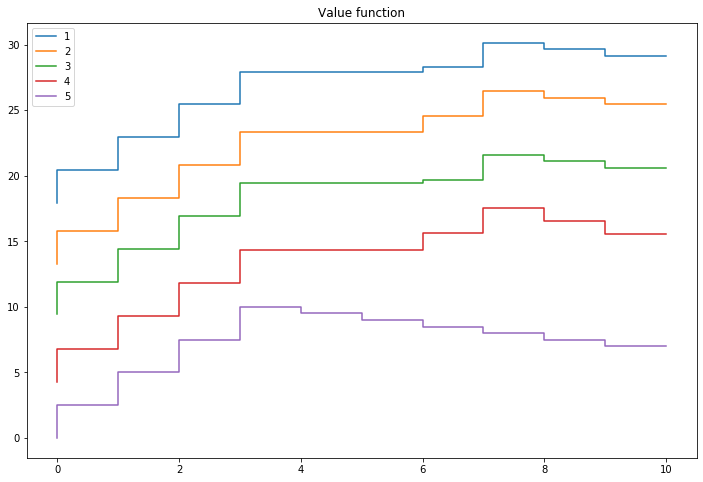

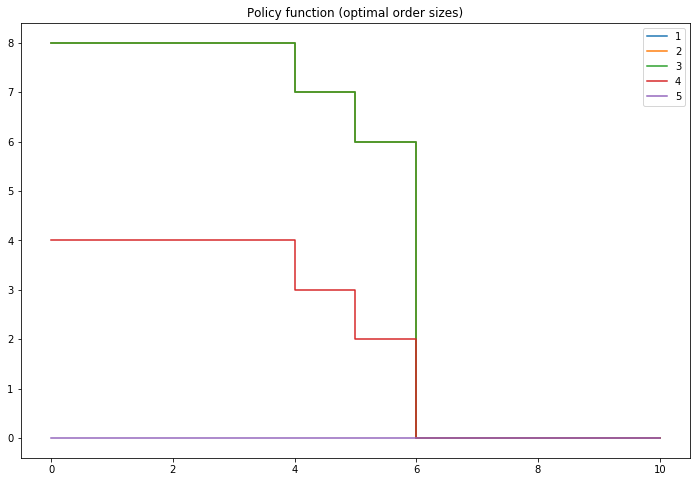

In [12]:
def plot_solution(model):
    plt.step(model.x,model.value)
    plt.legend([f'{i+1}' for i in range(model.value.shape[1])])
    plt.title('Value function')
    plt.show()
    plt.step(model.x,model.policy)
    plt.legend([f'{i+1}' for i in range(model.policy.shape[1])])
    plt.title('Policy function (optimal order sizes)')
    plt.show()

plot_solution(model)

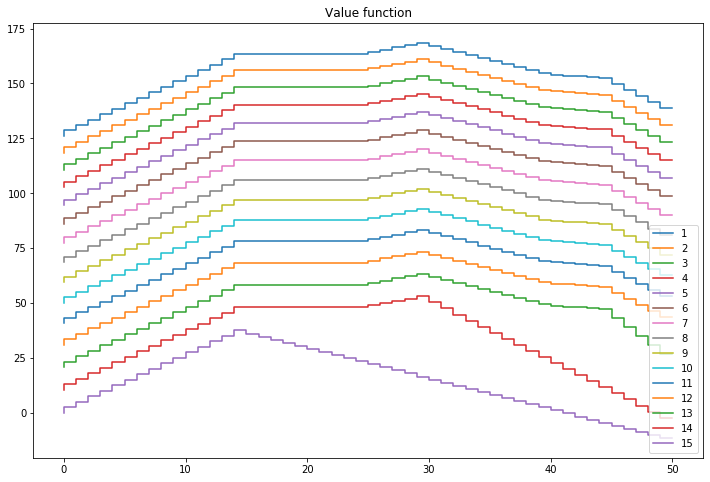

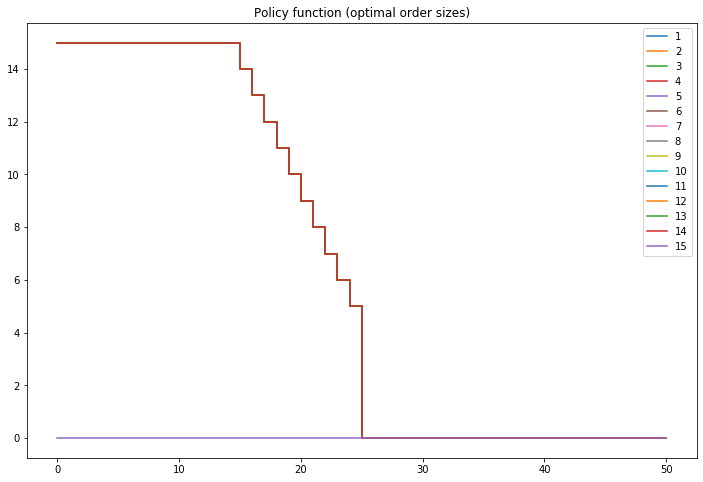

In [13]:
mod = inventory_model(label='production',max_inventory=50)
mod.demand = 15
mod.c = 5
mod.p = 2.5
mod.r = 1.4
mod.β = 0.975
mod = solver_backwards_induction(mod,T=15)
plot_solution(mod)

#### Next steps

- Stochastic demand  
- Infinite horizon  


More appropriate setup for the dynamic programming solution, so today only a simple special case

### Further learning resources

- 📖 Adda and Russell Cooper “Dynamic Economics. Quantitative Methods and Applications.” *Chapters: 2, 3.3*  
- Bellman equation [https://en.wikipedia.org/wiki/Bellman_equation](https://en.wikipedia.org/wiki/Bellman_equation)  
- Computer science view on DP [https://www.techiedelight.com/introduction-dynamic-programming](https://www.techiedelight.com/introduction-dynamic-programming)  
- Popular optimal stopping [https://www.americanscientist.org/article/knowing-when-to-stop](https://www.americanscientist.org/article/knowing-when-to-stop)  